In [49]:
from time import sleep
from numpy import *
import matplotlib.pyplot as plt

In [68]:
def get_data(filename):
    datamatrix = []
    labelmatrix = []

    fr = open(filename)
    for line in fr.readlines():
        lineArr = line.strip().split(',')
        datamatrix.append([float(lineArr[0]), float(lineArr[1])]) #datamatrix.append([1.0, float(lineArr[0]), float(lineArr[1])])
        labelmatrix.append(int(lineArr[2]))
    return datamatrix, labelmatrix

def plot_fit(fit_line, datamatrix, labelmatrix, b):
    weights = fit_line.getA()
    dataarray = asarray(datamatrix)
    n = dataarray.shape[0]

    # Keep track of the two classes in different arrays so they can be plotted later...
    xcord1 = []
    ycord1 = []
    xcord2 = []
    ycord2 = []
    for i in range(n):
        if int(labelmatrix[i]) == 1:
            xcord1.append(dataarray[i, 0]) #i, 1
            ycord1.append(dataarray[i, 1]) #i, 2
        else:
            xcord2.append(dataarray[i, 0]) #i, 1
            ycord2.append(dataarray[i, 1]) #i, 2
    fig = plt.figure()

    # Plot the data as points with different colours
    ax = fig.add_subplot(111)
    ax.scatter(xcord1, ycord1, s=30, c='red', marker='s')
    ax.scatter(xcord2, ycord2, s=30, c='green')

    # Plot the best-fit line
    x = arange(-1.5, 6.5, 0.1)
    y = ( - weights[0] * x) / weights[1]+b #descent not acsent (-weights[0] - weights[1] * x) / weights[2] 
    ax.plot(x, y)

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()   
    
def accuracy(labels, hypotheses):
    count = 0.0
    correct = 0.0

    for l, h in zip(labels, hypotheses):
        count += 1.0
        if l == h:
            correct += 1.0
    return correct / count


def print_confusion_matrix(labels, hypotheses):
    tp = 0.0
    tn = 0.0
    fp = 0.0
    fn = 0.0
    count = 1.0
    for l, h in zip(labels, hypotheses):
        count += 1.0
        if l == 1 and h == 1:
            tp += 1.0
        elif l == 1 and h == 0:
            tn += 1.0
        elif l == 0 and h == 0:
            fn += 1.0
        else:
            tn += 1
    print ('-----------------------------')
    print ('\tConfusion Matrix')
    print ('-----------------------------')
    print ('\t\tPredicted')
    print ('\tActual\tNO\tYES')
    print ('-----------------------------')
    print ('\tNO\t', tn, '\t', fp)
    print ('-----------------------------')
    print ('\tYES\t', fn, '\t', tp)
    print ('-----------------------------')

In [69]:
class svm_basic:
    def __init__(self,dataMatIn, classLabels, C, toler):  # Initialize the structure with the parameters
        self.weights = None
        self.X = dataMatIn
        self.labelMat =classLabels
        self.C = C
        self.tol = toler
        self.m = shape(dataMatIn)[0]
        self.alphas = mat(zeros((self.m,1)))
        self.b = 0
        self.eCache = mat(zeros((self.m,2))) #first column is valid flag
        
    def fit(self):
        m, n = shape(self.X)
        self.weights = zeros((n,1))
        for i in range(self.m):
            self.weights += multiply(alphas[i]*self.labelMat[i],self.X[i,:].T)
        return self.weights 
    
    def dist(self, point):
        ret = mat(point) * self.weights
        return ret[0][0] + self.b
    
    def predict(self, X):
        hypotheses = []
        for x in X:
            prob = self.dist(x)
            if prob > 0:
                hypotheses.append(1)
            else:
                hypotheses.append(-1)
        return hypotheses
        
    def selectJrand(self, i):
        j=i #we want to select any J not equal to i
        while (j==i):
            j = int(random.uniform(0,self.m))
        return j

    def clipAlpha(self, aj, H,L):
        if aj > H: 
            aj = H
        if L > aj:
            aj = L
        return aj
    
    def calcEkK(self, k):
        fXk = float(multiply(self.alphas,self.labelMat).T*(self.X*self.X[k,:].T)) + self.b
        Ek = fXk - float(self.labelMat[k])       
        return Ek

    def selectJK(self, i,  Ei):         #this is the second choice -heurstic, and calcs Ej
        maxK = -1; maxDeltaE = 0; Ej = 0
        self.eCache[i] = [1,Ei]  #set valid #choose the alpha that gives the maximum delta E
        validEcacheList = nonzero(self.eCache[:,0].A)[0]
        if (len(validEcacheList)) > 1:
            for k in validEcacheList:   #loop through valid Ecache values and find the one that maximizes delta E
                if k == i: continue #don't calc for i, waste of time
                Ek = self.calcEkK(k)
                deltaE = abs(Ei - Ek)
                if (deltaE > maxDeltaE):
                    maxK = k; maxDeltaE = deltaE; Ej = Ek
            return maxK, Ej
        else:   #in this case (first time around) we don't have any valid eCache values
            j = self.selectJrand(i)
            Ej = self.calcEkK(j)
        return j, Ej

    def updateEkK(self, k):#after any alpha has changed update the new value in the cache
        Ek = self.calcEkK(k)
        self.eCache[k] = [1,Ek]

    def innerLK(self, i):
        Ei = self.calcEkK(i)
        if ((self.labelMat[i]*Ei < -self.tol) and (self.alphas[i] < self.C)) or ((self.labelMat[i]*Ei > self.tol) and (self.alphas[i] > 0)):
            j,Ej = self.selectJK(i, Ei) #this has been changed from selectJrand
            alphaIold = self.alphas[i].copy(); alphaJold = self.alphas[j].copy();
            if (self.labelMat[i] != self.labelMat[j]):
                L = max(0, self.alphas[j] - self.alphas[i])
                H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
            else:
                L = max(0, self.alphas[j] + self.alphas[i] - self.C)
                H = min(self.C, self.alphas[j] + self.alphas[i])
            if L==H: #print("L==H"); 
                return 0
            eta = 2.0 * self.X[i,:]*self.X[j,:].T - self.X[i,:]*self.X[i,:].T - self.X[j,:]*self.X[j,:].T
            if eta >= 0: 
                #print("eta>=0"); 
                return 0
            self.alphas[j] -= self.labelMat[j]*(Ei - Ej)/eta
            self.alphas[j] = self.clipAlpha(self.alphas[j],H,L)
            self.updateEkK(j) #added this for the Ecache
            if (abs(self.alphas[j] - alphaJold) < 0.00001): 
                #print("j not moving enough"); 
                return 0
            self.alphas[i] += self.labelMat[j]*self.labelMat[i]*(alphaJold - self.alphas[j])#update i by the same amount as j
            self.updateEkK(i) #added this for the Ecache                    #the update is in the oppostie direction
            b1 = self.b - Ei- self.labelMat[i]*(self.alphas[i]-alphaIold)*self.X[i,:]*self.X[i,:].T - self.labelMat[j]*(self.alphas[j]-alphaJold)*self.X[i,:]*self.X[j,:].T
            b2 = self.b - Ej- self.labelMat[i]*(self.alphas[i]-alphaIold)*self.X[i,:]*self.X[j,:].T - self.labelMat[j]*(self.alphas[j]-alphaJold)*self.X[j,:]*self.X[j,:].T
            if (0 < self.alphas[i]) and (self.C > self.alphas[i]): self.b = b1
            elif (0 < self.alphas[j]) and (self.C > self.alphas[j]): self.b = b2
            else: self.b = (b1 + b2)/2.0
            return 1
        else: return 0

    def smoPK(self, maxIter):    #full Platt SMO        
        iter = 0
        entireSet = True; alphaPairsChanged = 0
        while (iter < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
            alphaPairsChanged = 0
            if entireSet:   #go over all
                for i in range(self.m):
                    alphaPairsChanged += self.innerLK(i)
                    #print("fullSet, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
                iter += 1
            else:#go over non-bound (railed) alphas
                nonBoundIs = nonzero((self.alphas.A > 0) * (self.alphas.A < self.C))[0]
                for i in nonBoundIs:
                    alphaPairsChanged += self.innerLK(i)
                    #print("non-bound, iter: %d i:%d, pairs changed %d" % (iter,i,alphaPairsChanged))
                iter += 1
            if entireSet: entireSet = False #toggle entire set loop
            elif (alphaPairsChanged == 0): entireSet = True
            #print("iteration number: %d" % iter)
        return self.b,self.alphas

b = [[-0.22724174]]
weights =
 [[ 0.60134587]
 [-0.49197924]]


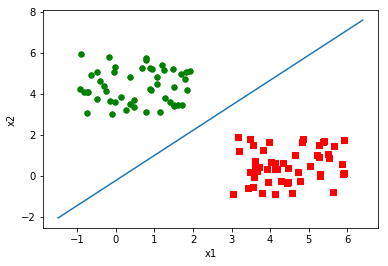

Accuracy: 1.0
-----------------------------
	Confusion Matrix
-----------------------------
		Predicted
	Actual	NO	YES
-----------------------------
	NO	 50.0 	 0.0
-----------------------------
	YES	 0.0 	 50.0
-----------------------------


In [70]:
dataArr, labelArr = get_data('/home/sarah/public_cs686//courseData/linearly_separable.csv')
test = svm_basic(mat(dataArr), mat(labelArr).transpose(), 1, 0.001)
b, alphas = test.smoPK(50)
w = test.fit()
w = asmatrix(w)
hypotheses = test.predict(dataArr)
print("b =", b)
print("weights =\n", w)
plot_fit(w, dataArr, labelArr, squeeze(asarray(b)))
print ('Accuracy:', accuracy(labelArr, hypotheses))
print_confusion_matrix(labelArr, hypotheses)